In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from pickle import dump , load
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import os

In [2]:
class AdultClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(13, 64)
        self.act1 = nn.ReLU()
        self.hidden2 = nn.Linear(64, 128)
        self.act2 = nn.ReLU()
        self.hidden3 = nn.Linear(128, 32)
        self.act3 = nn.ReLU()
        self.hidden4 = nn.Linear(32, 16)
        self.act4 = nn.ReLU()
        self.output = nn.Linear(16, 1)
        self.act_output = nn.Sigmoid()
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.dropout(self.act1(self.hidden1(x)))
        x = self.dropout(self.act2(self.hidden2(x)))
        x = self.dropout(self.act3(self.hidden3(x)))
        x = self.dropout(self.act4(self.hidden4(x)))
        # x = self.output(x)
        x = self.act_output(self.output(x))
        return x


def evaluate(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
    accuracy = (y_pred.round() == y_test).float().mean()
    return accuracy

    
def create_and_train_model(X_train, y_train, X_test, y_test, num_epochs, seed):
    torch.manual_seed(seed)
    
    model = AdultClassifier()
    batch_size = 128
    loss_fn = nn.BCELoss() 
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    model.eval()
    accuracy = evaluate(model, X_test, y_test)
    print('accuracy before training {}'.format(accuracy))
    model.train()
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        for i in range(0, len(X_train), batch_size):
            Xbatch = X_train[i:i+batch_size]
            y_pred = model(Xbatch)
            ybatch = y_train[i:i+batch_size]
            loss = loss_fn(y_pred, ybatch)
            # print(loss)
            loss.backward()
            optimizer.step()
        # print(loss.tolist())
        # evaluate model on each epoch
    model.eval()
    accuracy = evaluate(model, X_test, y_test)
    print(f'Finished epoch {epoch},  accuracy {accuracy}')
    return model


def create_data(train_df_loc, test_df_loc, scaler):
    train = pd.read_csv('./../train_balanced.csv')

    test = pd.read_csv('./../test_balanced.csv')
    X_train = train.iloc[:, 0:13].values
    y_train = train.iloc[:, 13].values
    # print(y_train)
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
    
    X_test = test.iloc[:, 0:13].values
    y_test = test.iloc[:, 13].values
    
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)
    
    X_train_np = X_train.numpy()
    X_test_np = X_test.numpy()  
    
    X_train_np[:, columns_to_standardize] = scaler.transform(X_train_np[:, columns_to_standardize])
    X_test_np[:, columns_to_standardize] = scaler.transform(X_test_np[:, columns_to_standardize])
    
    # Convert back to PyTorch tensors
    X_train = torch.from_numpy(X_train_np).type(torch.float) 
    X_test = torch.from_numpy(X_test_np).type(torch.float)
    
    return X_train, y_train, X_test, y_test


def create_list_of_model(count, X_train, y_train, X_test, y_test, num_epochs):
    list_of_models = []
    for i in range(count):
        model = create_and_train_model(X_train, y_train, X_test, y_test, num_epochs, i)
        list_of_models.append(model)
    return list_of_models

def load_model():
    model = torch.load('./../model_training/adult_credit__model')
    model.eval()
    return model

def eval_model(model, input, scaler, columns_to_standardize):
    model.eval()
    # print(input)
    input = input.reshape(-1, 13)
    input = torch.tensor(input, dtype=torch.float32)
    input = input.numpy()
    input[:, columns_to_standardize] = scaler.transform(input[:, columns_to_standardize])
    input = torch.from_numpy(input).type(torch.float)
    with torch.no_grad():
        prob = model(input)
    return prob.tolist()[0][0]

def evaluate_model_for_df(df , model_list, scaler, columns_to_standardize):
    probability_list = []
    if df.shape[0] == 0:
        return 0
    else:
        for index, row in df.iterrows():
            counterfactual_success =[]
            x = row.to_numpy()
            for model in model_list:
                prob = eval_model(model, x, scaler, columns_to_standardize)
                if prob > 0.5:
                    counterfactual_success.append(1)
                else:
                    counterfactual_success.append(0)
            probability_list.append(sum(counterfactual_success)/len(counterfactual_success))
        return sum(probability_list)/len(probability_list)

In [35]:
def calculate_robustness(input_data_loc, dice_loc, ge_cf_loc, ge_nsga2_loc, certif_cf_loc, model_list, scaler, columns_to_standardize):
    metric_dict = {'dice_robustness' : [],
                   'Our_method_robustness' : [],
                   'certif_robustness' : [],
                   'GE_NSGAII_robustness': []}
    
    output_dict = {}
        
    for i in os.listdir(input_data_loc):
        if i=='.DS_Store':
            continue
        dice_df = pd.read_csv(dice_loc +  i + '.csv')
        dice_df.drop(columns=['outcome'], inplace=True)
        Our_method_df  = pd.read_csv(ge_cf_loc +  i + '.csv')
        certif_df = pd.read_csv(certif_cf_loc +  i + '.csv')
        NSGAII_df = pd.read_csv(ge_nsga2_loc +  i + '.csv')
        
        
        metric_dict['dice_robustness'].append(evaluate_model_for_df(dice_df, model_list, scaler, columns_to_standardize ))
        metric_dict['Our_method_robustness'].append(evaluate_model_for_df(Our_method_df, model_list, scaler, columns_to_standardize))
        metric_dict['certif_robustness'].append(evaluate_model_for_df(certif_df, model_list, scaler, columns_to_standardize))
        metric_dict['GE_NSGAII_robustness'].append(evaluate_model_for_df(NSGAII_df, model_list, scaler, columns_to_standardize))
    
    for key, value in metric_dict.items():
        output_dict[key] = sum(value)/ len(value)
        
        
    return output_dict, metric_dict


In [19]:
columns_to_standardize = [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12]
scaler = load(open('./../model_training/StandardScaler.pkl', 'rb'))
model_orig = load_model()

input_data_loc = './../output/NSGAIII_multi/'
dice_loc = 'Dice_cf/'
ge_cf_loc = 'Ge_cf/'
ge_nsga2_loc = 'Ge_NSGAII_cf/'
certif_cf_loc = 'Certif_cf/'
train_df_loc = "./../train_balanced.csv"
test_df_loc = "./../test_balanced.csv"


In [20]:
X_train, y_train, X_test, y_test = create_data(train_df_loc, test_df_loc, scaler)

In [21]:
list_of_models = create_list_of_model(40, X_train, y_train, X_test, y_test, num_epochs=100)

accuracy before training 0.4964262545108795
Finished epoch 99,  accuracy 0.810049831867218
accuracy before training 0.5172189474105835
Finished epoch 99,  accuracy 0.8081005215644836
accuracy before training 0.4964262545108795
Finished epoch 99,  accuracy 0.8094000220298767
accuracy before training 0.4964262545108795
Finished epoch 99,  accuracy 0.8111327886581421
accuracy before training 0.5040069222450256
Finished epoch 99,  accuracy 0.8087502717971802
accuracy before training 0.4964262545108795
Finished epoch 99,  accuracy 0.7738791704177856
accuracy before training 0.4964262545108795
Finished epoch 99,  accuracy 0.7927225232124329
accuracy before training 0.4964262545108795
Finished epoch 99,  accuracy 0.7970543503761292
accuracy before training 0.4964262545108795
Finished epoch 99,  accuracy 0.8091834783554077
accuracy before training 0.5035737752914429
Finished epoch 99,  accuracy 0.8050682544708252
accuracy before training 0.5035737752914429
Finished epoch 99,  accuracy 0.807883

In [36]:
output_dict, metric_dict = calculate_robustness(input_data_loc, dice_loc, ge_cf_loc, ge_nsga2_loc, certif_cf_loc, list_of_models, scaler, columns_to_standardize)

In [37]:
metric_dict

{'dice_robustness': [1.0,
  1.0,
  0.985,
  1.0,
  0.9949999999999999,
  1.0,
  0.8,
  0.9,
  1.0,
  1.0,
  0.875,
  0.9125000000000001,
  1.0,
  0.805,
  1.0,
  0.8654411764705884,
  1.0,
  0.9765624999999999,
  0.96875,
  1.0,
  0.9,
  1.0,
  0.795,
  1.0,
  1.0,
  1.0,
  1.0,
  0.9980769230769231,
  1.0,
  0.9],
 'Our_method_robustness': [1.0,
  0.95,
  0.9049999999999999,
  0.89,
  0.5900000000000001,
  0.6859375,
  0.79,
  0.805,
  0.48906250000000007,
  1.0,
  0.8774999999999998,
  0.85625,
  0.925,
  1.0,
  0.81875,
  0.20992647058823527,
  1.0,
  0.30937499999999996,
  0.6749999999999999,
  0.6781250000000001,
  0.9428571428571428,
  1.0,
  0.9949999999999999,
  0.7607142857142858,
  1.0,
  1.0,
  0.825,
  0.8288461538461538,
  0.5125,
  0.796875],
 'certif_robustness': [0.7916666666666666,
  0.8305555555555555,
  0.9833333333333333,
  0.9055555555555556,
  0.9194444444444445,
  0.8333333333333334,
  0.7861111111111111,
  0.9472222222222223,
  1.0,
  0.9527777777777777,
  0.988

In [40]:
output_dict

{'dice_robustness': 0.9558776866515836,
 'Our_method_robustness': 0.8038906351001939,
 'certif_robustness': 0.892222222222222,
 'GE_NSGAII_robustness': 0.8174201643264142}

In [38]:
import matplotlib.pyplot as plt

def plot_bar_graph(data_dict, title="Bar Graph", xlabel="Labels", ylabel="Values"):
    
    labels = list(data_dict.keys())
    values = list(data_dict.values())
    
    plt.figure(figsize=(8, 6))
    plt.bar(labels, values, color='skyblue', width=0.4)
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

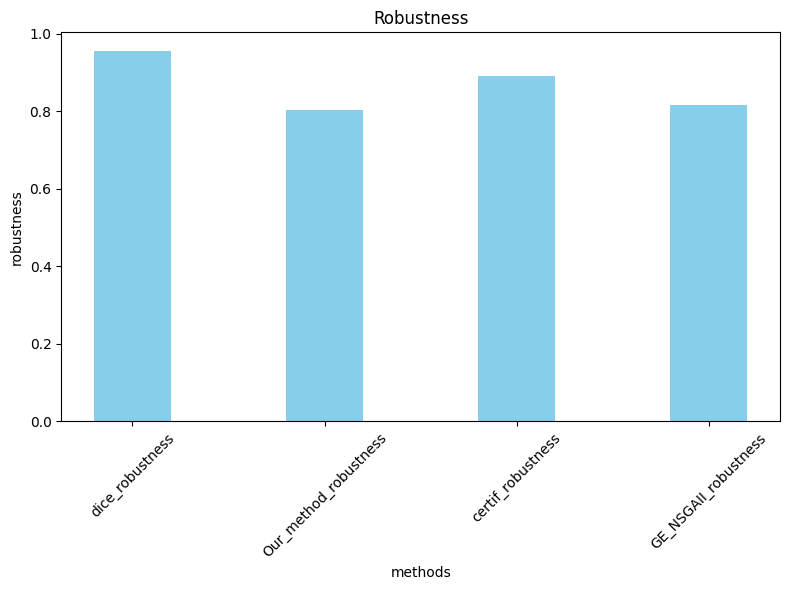

In [39]:
plot_bar_graph(output_dict, title="Robustness", xlabel="methods", ylabel="robustness")